# GPN Intelligence Cup 2020: Data Science

## 1. Анализ исходных данных 

In [235]:
import pandas as pd
import numpy as np

### 1.1. Анализ данных по продажам

In [647]:
sales = pd.read_parquet('sales.parquet')

In [648]:
sales.shape

(5081459, 6)

In [649]:
sales.head(15)

,date,shop_id,owner,number_of_counters,goods_type,total_items_sold
0,2146-01-01,0,Рейдеры,4,Съедобный хлам,6.0
1,2146-01-01,0,Рейдеры,4,Хлам,26.0
2,2146-01-01,0,Рейдеры,4,Бензак,10537.0
3,2146-01-01,1,Рейдеры,5,Съедобный хлам,17.0
4,2146-01-01,1,Рейдеры,5,Хлам,9.0
5,2146-01-01,1,Рейдеры,5,Броня и одежда,2.0
6,2146-01-01,1,Рейдеры,5,Бензак,5510.0
7,2146-01-01,1,Рейдеры,5,Солярка,238.0
8,2146-01-01,2,Рейдеры,4,Ядер-Кола,37.0
9,2146-01-01,2,Рейдеры,4,Съедобный хлам,115.0


In [650]:
sales.isna().values.any() # Отлично, пропусков в данных по продажам нет

False

In [651]:
sales['owner'].value_counts()

Рейдеры                       3906481
Воины полураспада              595022
Стервятники                    275076
Последователи Апокалипсиса     169120
Бомбисты                       135760
Name: owner, dtype: int64

In [652]:
sales['number_of_counters'].value_counts()

6     2358414
8     1151018
4      815438
10     389423
5      106718
9       81733
12      77329
7       65052
11      12201
14       6778
13       5632
3        3972
1        2909
16        919
17        893
15        855
2         845
18        517
19        510
20        200
21         81
22         15
23          7
Name: number_of_counters, dtype: int64

In [653]:
sales['goods_type'].value_counts()

Бензак                615722
Солярка               585314
Съедобный хлам        551292
Хлам                  540485
Патроны               505188
Броня и одежда        493856
Ядер-Кола             474912
Медпрепараты и еда    413378
Модификации тачки     353090
Жидкости для тачки    320589
Оружие                227633
Name: goods_type, dtype: int64

In [654]:
sales['total_items_sold'].value_counts()[-1] # проверить на отрицательные значения

10

### 1.2. Анализ данных по характеристикам магазинов

In [655]:
shops = pd.read_parquet('shops.parquet')

In [656]:
shops.shape

(845, 8)

In [657]:
shops.head(5) # замечен первый None 

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
0,705,В центре,Крепость Джита,2109,нет,да,да,1
1,601,В центре,Суховей,2137,нет,нет,нет,4
2,530,В центре,Храм Фритюра,2118,нет,нет,нет,None
3,91,В центре,Убежище Жестянщика,2135,нет,нет,да,1
4,100,На отшибе,Убежище Жестянщика,2135,да,нет,да,2


In [658]:
shops.isna().values.any() # подтверждение присутствия пропусков в данных 

True

In [659]:
shops['year_opened'].value_counts()[:2] # описать, как мы интерпретируем значения 

 2139    94
-1       63
Name: year_opened, dtype: int64

In [660]:
shops['shop_type'].value_counts()

1    385
2    150
3    115
4     63
Name: shop_type, dtype: int64

In [661]:
shops['neighborhood'].value_counts()

В центре     309
У тоннеля    169
На отшибе    115
У ночлега     81
У воды        77
Промзона      62
С краю        32
Name: neighborhood, dtype: int64

### 1.3. Анализ данных о разбивке городов по локациям

In [662]:
cities = pd.read_parquet('cities.parquet')

In [663]:
cities.shape

(15, 2)

In [664]:
cities

,city,location
0,Крепость Джита,Скалистый Могильник
1,Суховей,Скалистый Могильник
2,Храм Фритюра,Скалистый Могильник
3,Убежище Жестянщика,Свистящие Степи
4,Газтаун,Радиоактивная Пустошь
5,Пасть,Свистящие Степи
6,Аэропорт,Скалистый Могильник
7,Равнина Маяка,Радиоактивная Пустошь
8,Дизельные Жилы,Свистящие Степи
9,Темница,Радиоактивная Пустошь


## 2. Выбор информативных признаков  

делаю таблицу id - good_type

In [665]:
sample = sales.groupby(['shop_id','goods_type'], as_index=False).aggregate({'total_items_sold' : 'sum'})

In [666]:
shop_info = sales.groupby(['shop_id','goods_type'], as_index=False).aggregate({'total_items_sold' : 'sum'})

In [667]:
shop_info.head(10)

,shop_id,goods_type,total_items_sold
0,0,Бензак,11647666.0
1,0,Броня и одежда,81.0
2,0,Жидкости для тачки,35.0
3,0,Съедобный хлам,1077.0
4,0,Хлам,1351.0
5,1,Бензак,9079168.0
6,1,Броня и одежда,1236.0
7,1,Жидкости для тачки,298.0
8,1,Солярка,1548661.0
9,1,Съедобный хлам,20340.0


In [668]:
goods = set(shop_info['goods_type'])
ids = set(shop_info['shop_id'])

In [669]:
df1 = pd.DataFrame({"shop_id":pd.Series(list(ids))}) # создаем колонку со списком shop_id 

In [670]:
for type in goods:
    df2 = sales[sales['goods_type'] == type].groupby('shop_id').aggregate({'total_items_sold' : 'sum'})
    df2 = df2.rename(columns={'total_items_sold': type})
    df1 = pd.merge(left=df1, right=df2, left_on='shop_id', right_on='shop_id',  how='outer')

In [671]:
df1

,shop_id,Броня и одежда,Модификации тачки,Медпрепараты и еда,Патроны,Солярка,Жидкости для тачки,Бензак,Съедобный хлам,Хлам,Ядер-Кола,Оружие
0,0,81.0,NaN,NaN,NaN,NaN,35.0,11647666.0,1077.0,1351.0,NaN,NaN
1,1,1236.0,NaN,NaN,NaN,1548661.0,298.0,9079168.0,20340.0,5321.0,NaN,NaN
2,2,21571.0,5527.0,3109.0,636472.0,1378414.0,3550.0,7953184.0,115414.0,39997.0,47141.0,2526.0
3,3,754.0,61.0,NaN,NaN,2399400.0,13286.0,23048831.0,32051.0,17724.0,5.0,30.0
4,4,13826.0,16925.0,37541.0,797282.0,3258548.0,15438.0,23389524.0,289664.0,79956.0,161995.0,844.0
...,...,...,...,...,...,...,...,...,...,...,...,...
840,840,48415.0,26988.0,96224.0,405407.0,3563307.0,15534.0,17566124.0,245789.0,112601.0,163479.0,11152.0
841,841,31991.0,17683.0,78876.0,551027.0,3484279.0,19501.0,19530586.0,269893.0,95302.0,150300.0,13614.0
842,842,45371.0,34233.0,193496.0,661920.0,4775790.0,38839.0,21984118.0,491745.0,114614.0,383469.0,26467.0
843,843,51099.0,17824.0,105411.0,855965.0,3479157.0,16586.0,24264734.0,335289.0,107085.0,192845.0,19941.0


In [672]:
df = df1.fillna(0)

In [673]:
df

,shop_id,Броня и одежда,Модификации тачки,Медпрепараты и еда,Патроны,Солярка,Жидкости для тачки,Бензак,Съедобный хлам,Хлам,Ядер-Кола,Оружие
0,0,81.0,0.0,0.0,0.0,0.0,35.0,11647666.0,1077.0,1351.0,0.0,0.0
1,1,1236.0,0.0,0.0,0.0,1548661.0,298.0,9079168.0,20340.0,5321.0,0.0,0.0
2,2,21571.0,5527.0,3109.0,636472.0,1378414.0,3550.0,7953184.0,115414.0,39997.0,47141.0,2526.0
3,3,754.0,61.0,0.0,0.0,2399400.0,13286.0,23048831.0,32051.0,17724.0,5.0,30.0
4,4,13826.0,16925.0,37541.0,797282.0,3258548.0,15438.0,23389524.0,289664.0,79956.0,161995.0,844.0
...,...,...,...,...,...,...,...,...,...,...,...,...
840,840,48415.0,26988.0,96224.0,405407.0,3563307.0,15534.0,17566124.0,245789.0,112601.0,163479.0,11152.0
841,841,31991.0,17683.0,78876.0,551027.0,3484279.0,19501.0,19530586.0,269893.0,95302.0,150300.0,13614.0
842,842,45371.0,34233.0,193496.0,661920.0,4775790.0,38839.0,21984118.0,491745.0,114614.0,383469.0,26467.0
843,843,51099.0,17824.0,105411.0,855965.0,3479157.0,16586.0,24264734.0,335289.0,107085.0,192845.0,19941.0


In [674]:
f = df.apply(np.sum, axis=1) # нормализация признаков
data1 = df.div(f.iloc[0], axis='columns')
data1['shop_id'] = df['shop_id']
data1

,shop_id,Броня и одежда,Модификации тачки,Медпрепараты и еда,Патроны,Солярка,Жидкости для тачки,Бензак,Съедобный хлам,Хлам,Ядер-Кола,Оружие
0,0,0.000007,0.000000,0.000000,0.000000,0.000000,0.000003,0.999782,0.000092,0.000116,0.000000e+00,0.000000
1,1,0.000106,0.000000,0.000000,0.000000,0.132930,0.000026,0.779314,0.001746,0.000457,0.000000e+00,0.000000
2,2,0.001852,0.000474,0.000267,0.054632,0.118317,0.000305,0.682664,0.009907,0.003433,4.046365e-03,0.000217
3,3,0.000065,0.000005,0.000000,0.000000,0.205953,0.001140,1.978405,0.002751,0.001521,4.291768e-07,0.000003
4,4,0.001187,0.001453,0.003222,0.068435,0.279699,0.001325,2.007648,0.024863,0.006863,1.390490e-02,0.000072
...,...,...,...,...,...,...,...,...,...,...,...,...
840,840,0.004156,0.002317,0.008259,0.034798,0.305858,0.001333,1.507795,0.021097,0.009665,1.403228e-02,0.000957
841,841,0.002746,0.001518,0.006770,0.047298,0.299074,0.001674,1.676415,0.023166,0.008180,1.290106e-02,0.001169
842,842,0.003894,0.002938,0.016609,0.056816,0.409932,0.003334,1.887015,0.042209,0.009838,3.291520e-02,0.002272
843,843,0.004386,0.001530,0.009048,0.073472,0.298635,0.001424,2.082772,0.028780,0.009192,1.655292e-02,0.001712


Добавим ещё некоторые наборы признаков из данных по характеристикам магазинов.

In [675]:
shops.head(5)

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
0,705,В центре,Крепость Джита,2109,нет,да,да,1
1,601,В центре,Суховей,2137,нет,нет,нет,4
2,530,В центре,Храм Фритюра,2118,нет,нет,нет,None
3,91,В центре,Убежище Жестянщика,2135,нет,нет,да,1
4,100,На отшибе,Убежище Жестянщика,2135,да,нет,да,2


In [676]:
shops.shape

(845, 8)

In [677]:
shops = shops.replace('да', 1) # преобразуем категориальные признаки в числовые
shops = shops.replace('нет', 0) # преобразуем категориальные признаки в числовые
shops = shops.fillna(0) # заполняем пропуски нулями

In [678]:
shops.head(5)

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
0,705,В центре,Крепость Джита,2109,0.0,1.0,1.0,1
1,601,В центре,Суховей,2137,0.0,0.0,0.0,4
2,530,В центре,Храм Фритюра,2118,0.0,0.0,0.0,0
3,91,В центре,Убежище Жестянщика,2135,0.0,0.0,1.0,1
4,100,На отшибе,Убежище Жестянщика,2135,1.0,0.0,1.0,2


в столбце year_opened заменим год со значением -1 на среднее значение по столбцу год. Почему нельзя оставить -1? Векторы будут слишком непохожими


In [679]:
shops[shops["year_opened"] == -1].count()

shop_id                        63
neighborhood                   63
city                           63
year_opened                    63
is_on_the_road                 63
is_with_the_well               63
is_with_additional_services    63
shop_type                      63
dtype: int64

In [680]:
mean_value = round(shops[shops["year_opened"]!= -1]["year_opened"].mean())

In [681]:
shops["year_opened"] = shops["year_opened"].replace(-1, mean_value)
shops["year_opened"] = shops["year_opened"]/10000

In [682]:
shops.head(5)

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
0,705,В центре,Крепость Джита,0.2109,0.0,1.0,1.0,1
1,601,В центре,Суховей,0.2137,0.0,0.0,0.0,4
2,530,В центре,Храм Фритюра,0.2118,0.0,0.0,0.0,0
3,91,В центре,Убежище Жестянщика,0.2135,0.0,0.0,1.0,1
4,100,На отшибе,Убежище Жестянщика,0.2135,1.0,0.0,1.0,2


теперь необходимо преобразовать признак neighborhood, который несомненно является информативным так как от окрестности и от района, в котором находится магазин зависит многое

In [683]:
shops['neighborhood'].value_counts()

В центре     309
У тоннеля    169
На отшибе    115
У ночлега     81
У воды        77
Промзона      62
С краю        32
Name: neighborhood, dtype: int64

In [684]:
set(shops['neighborhood']) # подумать, как обрабатывать эти признаки 

{'В центре',
 'На отшибе',
 'Промзона',
 'С краю',
 'У воды',
 'У ночлега',
 'У тоннеля'}

In [685]:
sh = shops[['shop_id', 'year_opened', 'is_on_the_road', 'is_with_additional_services']]

In [686]:
data2 = pd.merge(left=data1, right=sh, left_on='shop_id', right_on='shop_id',  how='outer')

In [687]:
data2

,shop_id,Броня и одежда,Модификации тачки,Медпрепараты и еда,Патроны,Солярка,Жидкости для тачки,Бензак,Съедобный хлам,Хлам,Ядер-Кола,Оружие,year_opened,is_on_the_road,is_with_additional_services
0,0,0.000007,0.000000,0.000000,0.000000,0.000000,0.000003,0.999782,0.000092,0.000116,0.000000e+00,0.000000,0.2136,0.0,0.0
1,1,0.000106,0.000000,0.000000,0.000000,0.132930,0.000026,0.779314,0.001746,0.000457,0.000000e+00,0.000000,0.2115,0.0,0.0
2,2,0.001852,0.000474,0.000267,0.054632,0.118317,0.000305,0.682664,0.009907,0.003433,4.046365e-03,0.000217,0.2115,0.0,1.0
3,3,0.000065,0.000005,0.000000,0.000000,0.205953,0.001140,1.978405,0.002751,0.001521,4.291768e-07,0.000003,0.2092,0.0,0.0
4,4,0.001187,0.001453,0.003222,0.068435,0.279699,0.001325,2.007648,0.024863,0.006863,1.390490e-02,0.000072,0.2108,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,840,0.004156,0.002317,0.008259,0.034798,0.305858,0.001333,1.507795,0.021097,0.009665,1.403228e-02,0.000957,0.2129,1.0,0.0
841,841,0.002746,0.001518,0.006770,0.047298,0.299074,0.001674,1.676415,0.023166,0.008180,1.290106e-02,0.001169,0.2129,0.0,0.0
842,842,0.003894,0.002938,0.016609,0.056816,0.409932,0.003334,1.887015,0.042209,0.009838,3.291520e-02,0.002272,0.2129,0.0,0.0
843,843,0.004386,0.001530,0.009048,0.073472,0.298635,0.001424,2.082772,0.028780,0.009192,1.655292e-02,0.001712,0.2129,0.0,0.0


In [688]:
shops['neighborhood']

0       В центре
1       В центре
2       В центре
3       В центре
4      На отшибе
         ...    
840    У тоннеля
841     В центре
842    У ночлега
843    У ночлега
844     В центре
Name: neighborhood, Length: 845, dtype: object

In [689]:
pd.get_dummies(shops["neighborhood"])

,В центре,На отшибе,Промзона,С краю,У воды,У ночлега,У тоннеля
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
840,0,0,0,0,0,0,1
841,1,0,0,0,0,0,0
842,0,0,0,0,0,1,0
843,0,0,0,0,0,1,0


In [690]:
data3 = pd.concat([data2,pd.get_dummies(shops["neighborhood"])], axis=1)

In [691]:
len(data3.columns)

22

In [692]:
data3.head()

,shop_id,Броня и одежда,Модификации тачки,Медпрепараты и еда,Патроны,Солярка,Жидкости для тачки,Бензак,Съедобный хлам,Хлам,...,year_opened,is_on_the_road,is_with_additional_services,В центре,На отшибе,Промзона,С краю,У воды,У ночлега,У тоннеля
0,0,0.000007,0.000000,0.000000,0.000000,0.000000,0.000003,0.999782,0.000092,0.000116,...,0.2136,0.0,0.0,1,0,0,0,0,0,0
1,1,0.000106,0.000000,0.000000,0.000000,0.132930,0.000026,0.779314,0.001746,0.000457,...,0.2115,0.0,0.0,1,0,0,0,0,0,0
2,2,0.001852,0.000474,0.000267,0.054632,0.118317,0.000305,0.682664,0.009907,0.003433,...,0.2115,0.0,1.0,1,0,0,0,0,0,0
3,3,0.000065,0.000005,0.000000,0.000000,0.205953,0.001140,1.978405,0.002751,0.001521,...,0.2092,0.0,0.0,1,0,0,0,0,0,0
4,4,0.001187,0.001453,0.003222,0.068435,0.279699,0.001325,2.007648,0.024863,0.006863,...,0.2108,0.0,1.0,0,1,0,0,0,0,0


In [695]:
pd.get_dummies(shops["shop_type"])

,0,1,2,3,4
0,0,1,0,0,0
1,0,0,0,0,1
2,1,0,0,0,0
3,0,1,0,0,0
4,0,0,1,0,0
...,...,...,...,...,...
840,0,0,0,0,1
841,0,0,0,0,1
842,0,0,0,1,0
843,0,0,0,1,0


In [696]:
data4 = pd.concat([data3,pd.get_dummies(shops["shop_type"])], axis=1)

In [697]:
data4.head()

,shop_id,Броня и одежда,Модификации тачки,Медпрепараты и еда,Патроны,Солярка,Жидкости для тачки,Бензак,Съедобный хлам,Хлам,...,Промзона,С краю,У воды,У ночлега,У тоннеля,0,1,2,3,4
0,0,0.000007,0.000000,0.000000,0.000000,0.000000,0.000003,0.999782,0.000092,0.000116,...,0,0,0,0,0,0,1,0,0,0
1,1,0.000106,0.000000,0.000000,0.000000,0.132930,0.000026,0.779314,0.001746,0.000457,...,0,0,0,0,0,0,0,0,0,1
2,2,0.001852,0.000474,0.000267,0.054632,0.118317,0.000305,0.682664,0.009907,0.003433,...,0,0,0,0,0,1,0,0,0,0
3,3,0.000065,0.000005,0.000000,0.000000,0.205953,0.001140,1.978405,0.002751,0.001521,...,0,0,0,0,0,0,1,0,0,0
4,4,0.001187,0.001453,0.003222,0.068435,0.279699,0.001325,2.007648,0.024863,0.006863,...,0,0,0,0,0,0,0,1,0,0


## 3. Выбор метрики качества кластеризации

среднее внутрикластерное расстояние, среднее межкластерное расстояние, комбинации функционалов и коэффициент силуэта

## 4. Реализация алгоритмов кластеризации

### 4.1. DBSCAN

In [705]:
df = data4.drop(columns=['shop_id'])
data = df.to_numpy()

In [620]:
data = data3.drop(columns=['shop_id', 'shop_type'])

In [607]:
data = data3.drop(columns='shop_type')

In [714]:
from sklearn.cluster import DBSCAN
 

dbscan = DBSCAN(eps=1.3, min_samples=4)# как выбирать параметры?
 
dbscan.fit(data)
 

algo_labels = dbscan.labels_
# Готово! Распечатаем метки принадлежности к кластерам
print(metrics.silhouette_score(data, algo_labels))
print(dbscan.labels_)

0.2932095009348355
[ 0  1  2  0  3  4  0  0  5  6  7  8  9  2  6 10  4 11  0  0 10  7  9  4
 10  0  4  0 12 13  4 14  0 13 24 14 10  2 14  7  2  4 15 10  6 14  9  0
  4  4  2 14  5  1 10  5  3  6  6  4  7  0  0 13  3  0 14  2  2  4  2  4
  2  0  6  6  3  2  6  2  5  0  4  3  4  8  0  0  0  4 16  8  4  6  7  2
  2  2 13  4  0 13 13  4 14 14  2  0  8  0 13  6  7 11 14  4  4 11 13  4
 13 14  6  4 17  6  2  0  3  0  2  6  6 16  5  0  2  2 13  0  1  2  7  2
  2  2  0  6  7  0  3  0  5  8  6  2  1  8 13 14  0 11  0  0  7 14  7  0
 18  9 14  6 13  2  0  2  0  5  6  7 12  0  2  2 14 13 15 19  2  3  0  6
  7 13  4 20  4  5  0  7  7 14 13  0  2 12 12 10 13  2 25  6 19  6  0 13
  2  6 14  7  4  7  6  7  2 10  6  3  6  2 10  6  0  2  1  6  5  0 18  0
  0 16  0  6  4  3 12  7 -1  4  0 13  7 10  2  5  7  2  6  2  2 12  2  4
 15  6 15  0  7  6  7  2  7  7 14 15  2 16  5  3  8 13 10 13  4 19  3  1
  2  6  2  6  4  0  1  8  6  1 13  4  6  4  4 15  0  9 16 22  1  6  7  6
 14  6  3  2  7  6  7  6  0  7 1

In [719]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2

print(data.shape)

X_new = SelectKBest(chi2, k=26).fit_transform(data, dbscan.labels_)
X_new.shape


(845, 26)


(845, 26)

[0.0061274  0.00617914 0.00468543 0.00539676 0.00594948 0.00613591
 0.00826446 0.00477849 0.00602349 0.00440332 0.00621951 0.00540717
 0.00242854 0.00351521 0.11355647 0.0786941  0.04705003 0.028572
 0.06363794 0.0538169  0.10283147 0.10301678 0.13030585 0.08392266
 0.0703334  0.04874809]


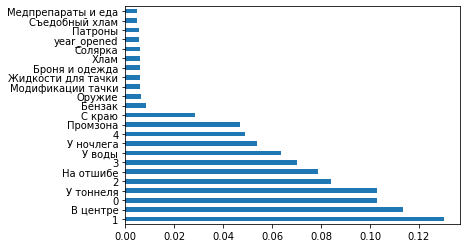

In [721]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

# UNIVARIATE SELECTION

# data = pd.read_csv('C:\\Users\\Excel\\Desktop\\Briefcase\\PDFs\\1-ALL PYTHON & R CODE SAMPLES\\Feature Selection - Machine Learning\\train.csv')
X = df #independent columns
y = dbscan.labels_    #target column i.e price range

   
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(23).plot(kind='barh')
plt.show()

### 4.2. K-Means

In [724]:
# Импортируем библиотеки
from sklearn import datasets
from sklearn.cluster import KMeans


# Описываем модель
model = KMeans(n_clusters=5) # подумать о количестве кластеров

# Проводим моделирование
model.fit(data)

# Предсказание на всем наборе данных
all_predictions = model.predict(data)

# Выводим предсказания

print(all_predictions)
print(metrics.silhouette_score(data2, all_predictions))

[3 4 4 3 2 3 3 3 2 3 3 3 2 4 3 3 3 0 3 3 3 1 2 3 3 3 3 3 1 2 3 3 3 2 0 3 3
 4 3 3 4 3 2 3 3 3 2 3 1 3 4 3 1 4 3 2 2 3 3 3 1 3 3 2 2 3 3 4 4 1 4 3 4 3
 3 3 2 4 3 4 2 1 1 2 3 3 3 3 3 3 0 3 3 3 3 4 4 4 2 3 3 2 2 3 3 3 4 3 3 3 2
 3 3 0 3 3 3 0 2 3 2 3 3 3 0 3 4 1 2 3 4 3 3 0 2 3 4 4 2 3 4 4 1 4 4 1 3 3
 3 3 2 3 2 3 3 4 4 3 2 3 3 0 3 3 3 3 3 3 2 2 3 3 2 4 3 4 3 2 3 3 0 3 4 4 3
 1 2 0 4 2 3 3 3 2 3 0 3 2 3 3 3 3 2 3 4 0 0 1 2 4 2 3 0 3 1 1 4 1 3 3 3 1
 1 3 1 3 1 2 3 4 3 3 3 4 4 3 2 3 2 3 3 0 3 3 3 2 0 3 0 3 3 2 3 3 4 2 3 4 3
 4 1 0 1 3 2 3 2 1 3 3 1 4 3 1 3 2 4 0 2 1 3 2 3 1 3 0 2 4 4 3 4 1 3 3 4 3
 3 4 2 3 1 3 3 2 1 2 0 0 4 1 3 3 1 1 2 4 1 1 1 1 3 3 0 4 0 2 2 2 0 1 1 2 1
 1 1 4 4 1 1 3 3 2 1 4 3 4 3 2 3 4 2 1 4 3 3 3 1 1 2 2 0 3 4 3 3 0 3 2 1 1
 1 1 1 3 3 1 3 4 4 3 1 3 3 4 1 4 3 4 3 4 1 0 4 1 1 0 4 0 3 4 3 2 1 4 3 1 4
 1 1 1 3 3 1 1 1 3 2 3 2 3 1 1 3 1 4 2 3 3 3 3 1 4 3 3 1 4 3 3 4 1 0 1 1 3
 1 1 3 3 3 3 2 1 3 0 3 3 2 2 4 0 0 0 3 1 4 3 1 1 4 3 2 4 1 3 3 2 0 4 4 0 2
 2 4 1 1 4 3 4 3 4 1 2 3 

### 4.3. Иерархическая кластеризация

In [725]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

In [726]:
mergings = linkage(data, method='complete')

In [727]:
mergings

array([[4.38000000e+02, 7.65000000e+02, 5.43453722e-03, 2.00000000e+00],
       [2.32000000e+02, 7.39000000e+02, 1.53688192e-02, 2.00000000e+00],
       [4.00000000e+01, 7.86000000e+02, 1.77592093e-02, 2.00000000e+00],
       ...,
       [1.67000000e+03, 1.68500000e+03, 3.88656646e+00, 5.67000000e+02],
       [1.68400000e+03, 1.68600000e+03, 4.02727661e+00, 8.15000000e+02],
       [1.68100000e+03, 1.68700000e+03, 5.44229887e+00, 8.45000000e+02]])

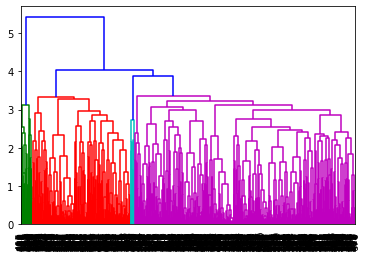

In [728]:
dendrogram(mergings,
#            labels=varieties,
           leaf_rotation=90,
           leaf_font_size=10,
           )
# plt.figure(figsize=(20,10))
# plt.figure(figsize=(1,1))
plt.show()

In [ ]:
настоить размер:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html 

In [ ]:
повекра качества результатов 

In [545]:
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering

In [600]:
alg = AgglomerativeClustering(n_clusters=5)
alg.fit(data)
alg.labels_

array([0, 0, 0, 4, 1, 1, 0, 0, 1, 3, 3, 1, 0, 0, 3, 3, 1, 0, 0, 0, 3, 3,
       0, 3, 1, 0, 1, 0, 2, 1, 1, 1, 0, 3, 1, 3, 1, 0, 1, 1, 0, 3, 1, 1,
       3, 1, 4, 0, 1, 1, 0, 1, 2, 0, 3, 3, 1, 3, 3, 1, 1, 0, 0, 1, 1, 0,
       3, 0, 4, 1, 4, 1, 0, 4, 3, 3, 1, 0, 1, 0, 3, 2, 1, 3, 3, 3, 0, 0,
       0, 1, 1, 1, 1, 3, 3, 0, 0, 0, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 1, 0,
       3, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 0, 0, 3,
       1, 1, 3, 0, 0, 0, 3, 0, 4, 0, 1, 2, 2, 1, 4, 3, 3, 0, 1, 0, 1, 1,
       3, 0, 0, 1, 3, 1, 4, 0, 0, 0, 1, 3, 3, 0, 1, 0, 3, 3, 1, 0, 0, 0,
       0, 1, 3, 3, 3, 4, 4, 0, 3, 1, 1, 1, 0, 1, 0, 3, 1, 3, 1, 3, 1, 2,
       0, 3, 3, 3, 3, 0, 4, 3, 3, 1, 3, 4, 1, 3, 3, 3, 2, 1, 4, 1, 1, 3,
       3, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 3, 4, 3, 0, 0, 3,
       4, 3, 3, 1, 3, 3, 3, 3, 0, 3, 1, 3, 4, 1, 3, 4, 1, 0, 2, 3, 2, 3,
       1, 3, 1, 2, 1, 1, 2, 2, 3, 2, 1, 3, 2, 3, 2, 2, 1, 3, 3, 2, 3, 1,
       3, 0, 0, 3, 4, 1, 3, 4, 4, 1, 1, 2, 1, 1, 2,

In [601]:
for linkage in ('ward', 'average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=5)
    clustering.fit(data)
    
    print(metrics.silhouette_score(data, clustering.labels_))

0.12082585223821937
0.17942524589922335
0.12336133554669082
0.017129940042098838


In [ ]:
0.5494873408232994
0.5539784808859305
0.5532355555181032
0.4302314021185118

In [ ]:
варианты алгоритмов

In [ ]:
algorithms.append(KMeans(n_clusters=10, random_state=1))
algorithms.append(AffinityPropagation())
algorithms.append(SpectralClustering(n_clusters=10, random_state=1,
                                     affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters=10))

In [390]:
print(metrics.silhouette_score(data2, algo_labels))
print(metrics.silhouette_score(data2, all_predictions))

0.1850243270794171
0.5344327316650442


## 5. Интерпритация результатов

In [605]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
# X, y = make_blobs(n_samples=500,
#                   n_features=2,
#                   centers=4,
#                   cluster_std=1,
#                   center_box=(-10.0, 10.0),
#                   shuffle=True,
#                   random_state=1)  # For reproducibility

def show_cluster(data2):
    data2 = data2.to_numpy()

    range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(data2) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(data2)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(data2, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data2, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(data2[:, 0], data2[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()

Automatically created module for IPython interactive environment


For n_clusters = 2 The average silhouette_score is : 0.15528095502003098
For n_clusters = 3 The average silhouette_score is : 0.14886210006738293
For n_clusters = 4 The average silhouette_score is : 0.1745795624426186
For n_clusters = 5 The average silhouette_score is : 0.1962943300148539
For n_clusters = 6 The average silhouette_score is : 0.1873839859494665
For n_clusters = 7 The average silhouette_score is : 0.1981246145221499
For n_clusters = 8 The average silhouette_score is : 0.19324265318942174
For n_clusters = 9 The average silhouette_score is : 0.19716815514237743
For n_clusters = 10 The average silhouette_score is : 0.22058422702218994
For n_clusters = 11 The average silhouette_score is : 0.219729141751573
For n_clusters = 12 The average silhouette_score is : 0.22338976538315616


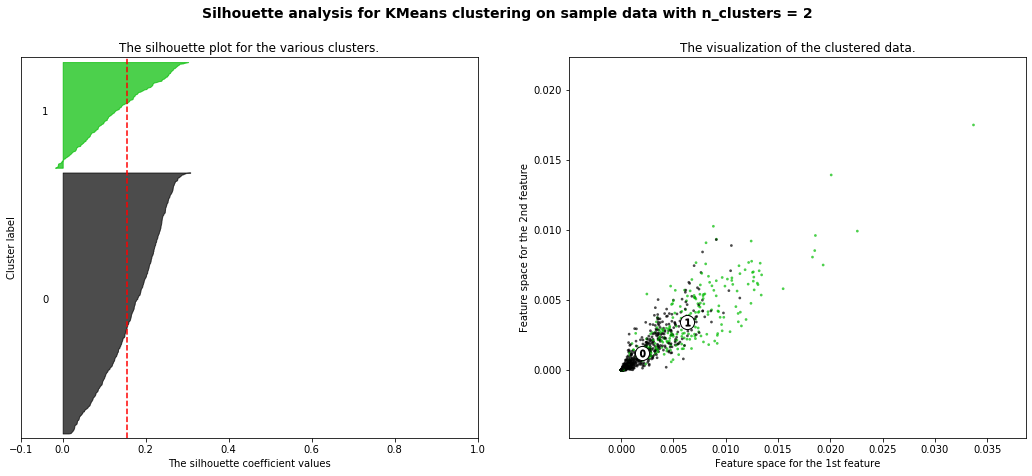

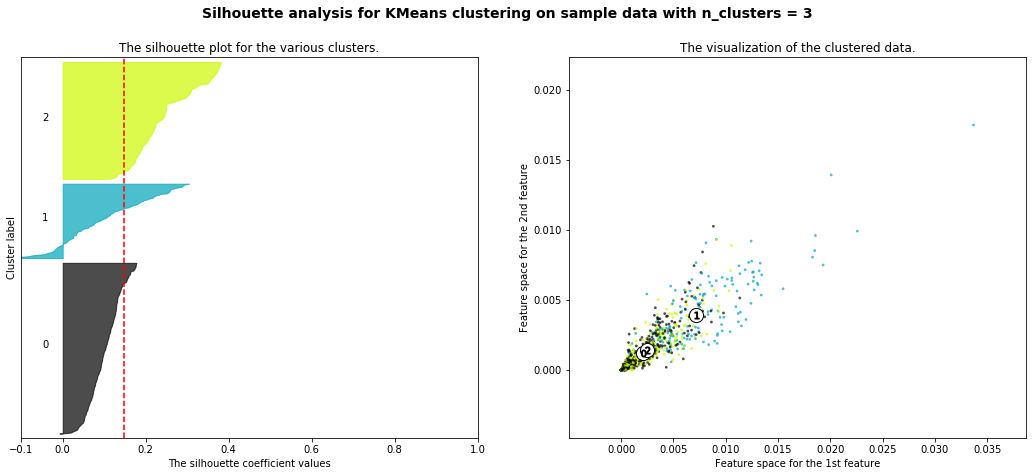

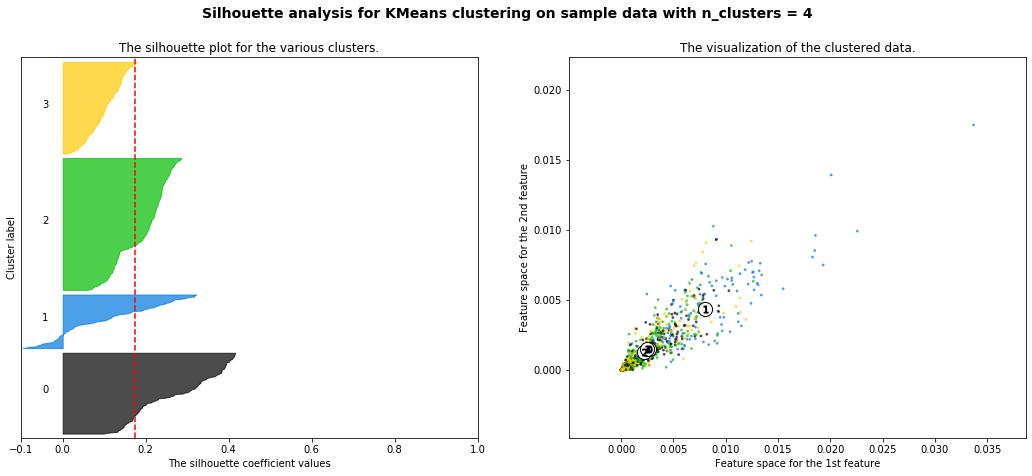

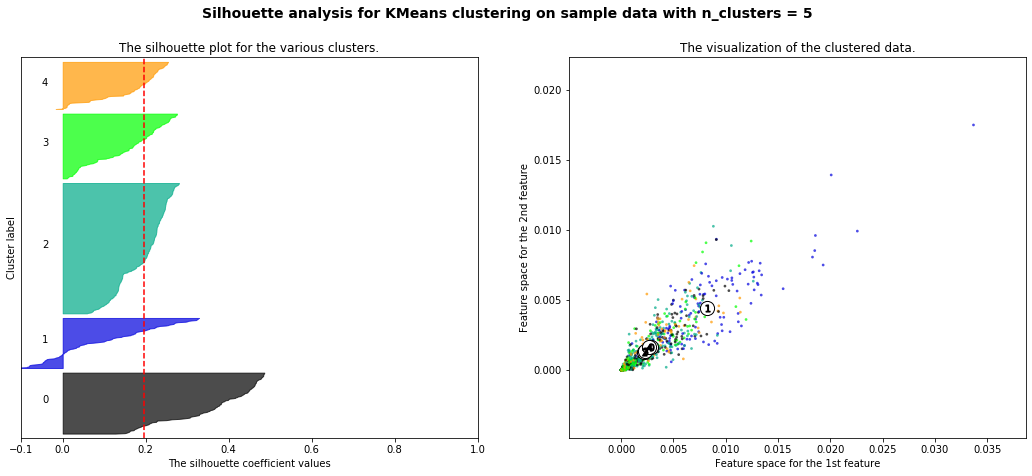

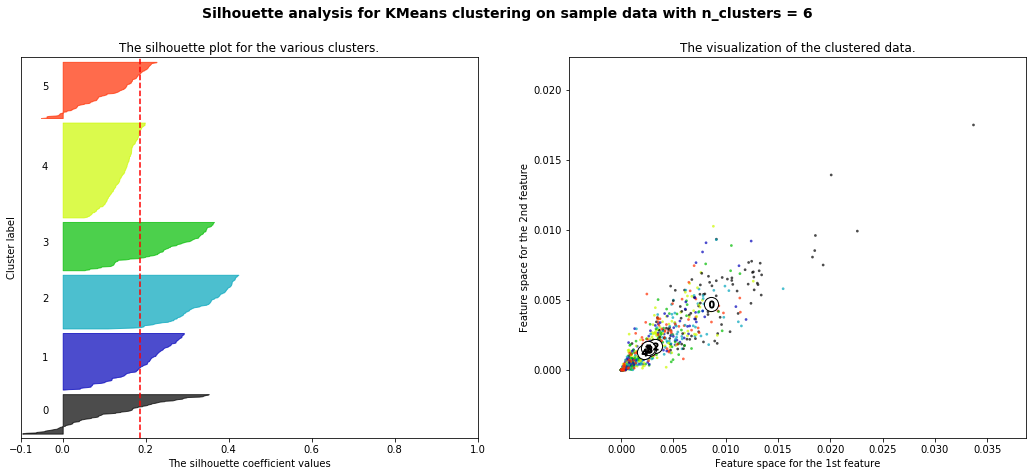

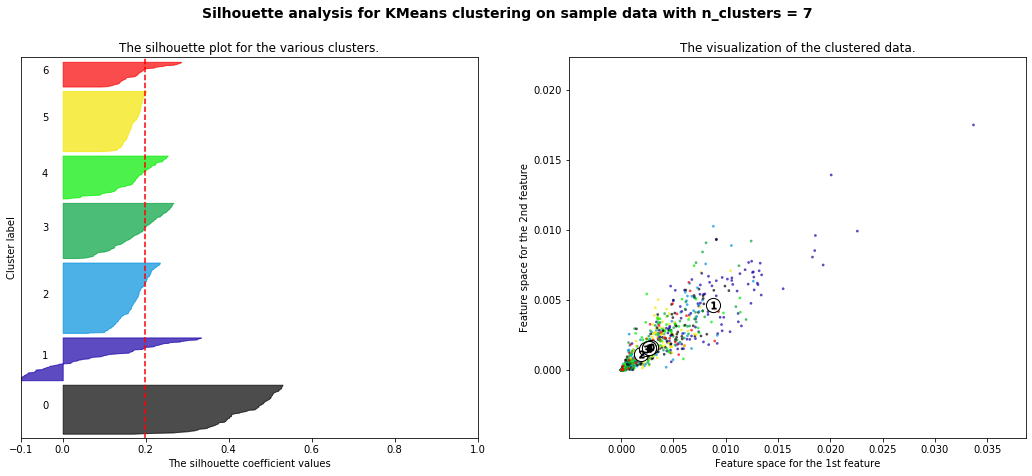

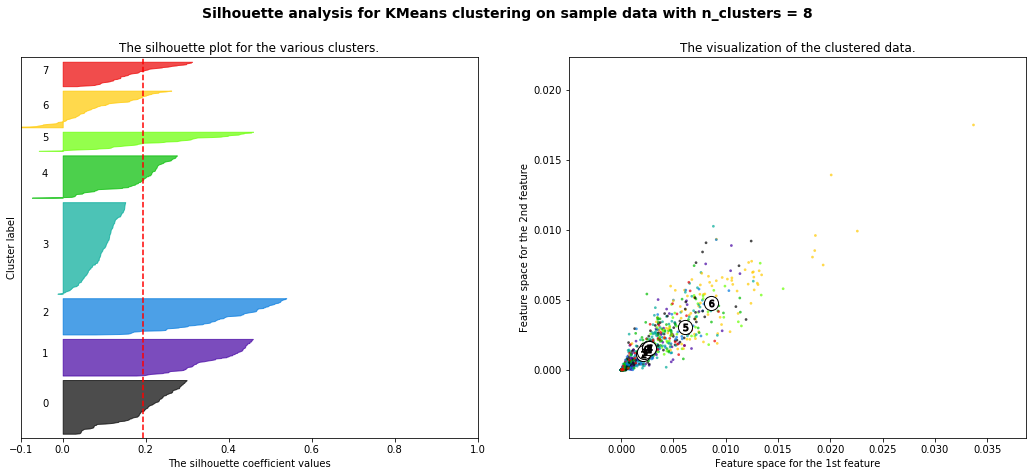

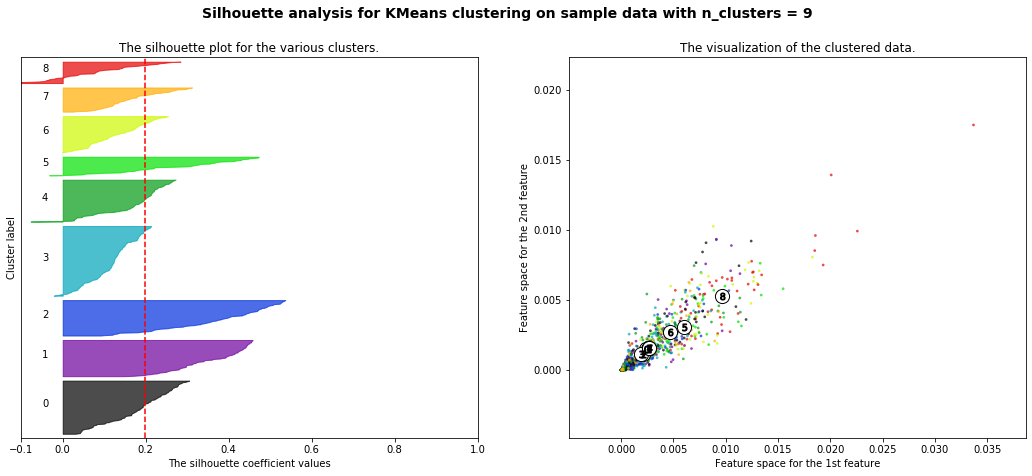

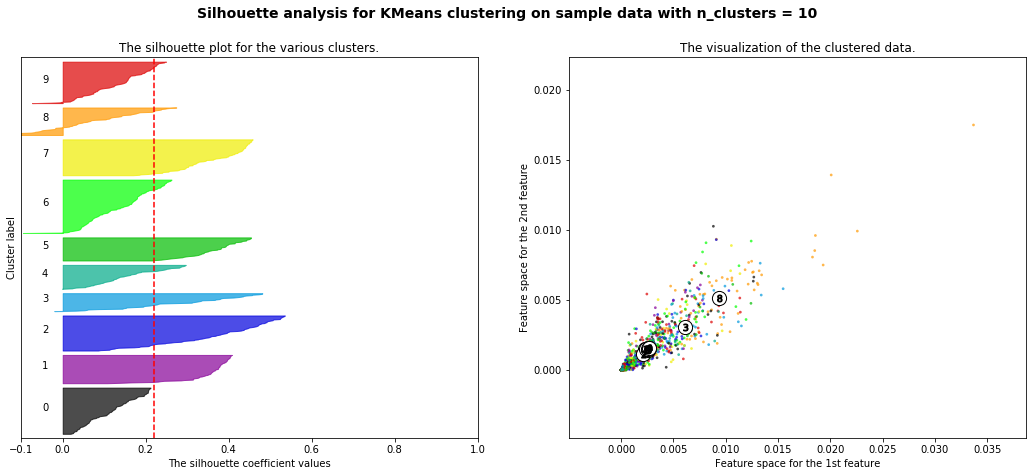

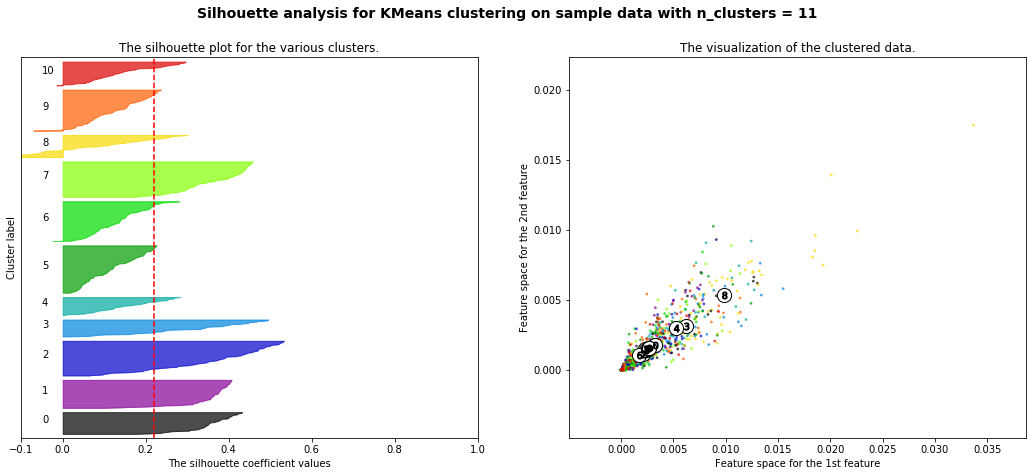

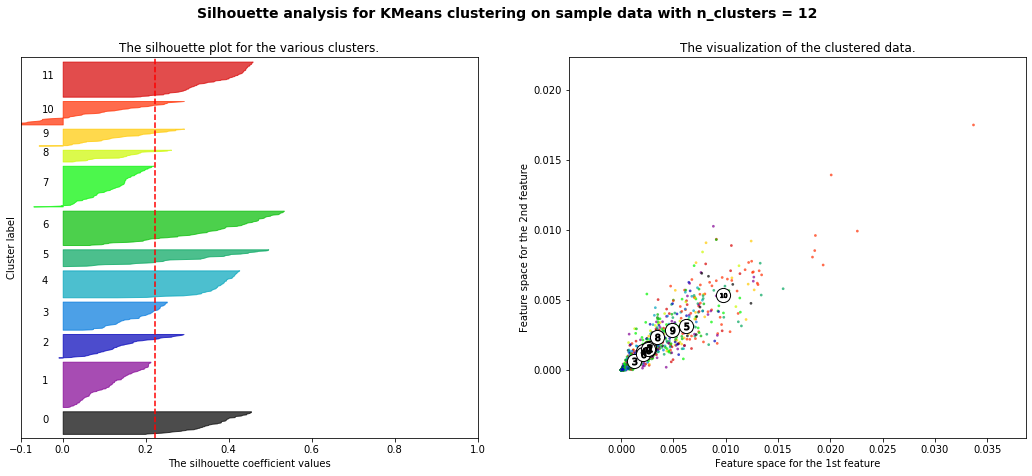

In [730]:
show_cluster(df)